<a href="https://colab.research.google.com/github/samiul272/ColabNotebooks/blob/master/freesoundv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.constraints import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

from functools import partial

import scipy
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import numpy as np
import librosa
import librosa.display

from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
from IPython.display import Audio

import progressbar

import h5py


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

W0621 10:32:40.740719 140608430872448 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

Download 100%.


In [0]:
%cd gdrive/"My Drive"/Freesound/Data/
%ls

/content/gdrive/My Drive/Freesound/Data


In [0]:
!kaggle competitions download -c freesound-audio-tagging-2019

  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 9.58MB/s]
  0% 0.00/571k [00:00<?, ?B/s]
100% 571k/571k [00:00<00:00, 36.9MB/s]
100% 2.24G/2.24G [00:40<00:00, 16.7MB/s]
100% 2.24G/2.24G [00:40<00:00, 59.2MB/s]
100% 20.0G/20.0G [12:06<00:00, 44.5MB/s]
100% 20.0G/20.0G [12:06<00:00, 29.6MB/s]
  0% 0.00/569k [00:00<?, ?B/s]
100% 569k/569k [00:00<00:00, 9.07MB/s]
100% 2.08G/2.08G [01:55<00:00, 21.6MB/s]
100% 2.08G/2.08G [01:55<00:00, 19.3MB/s]


In [0]:
import progressbar
file_ids = ['1-AIWG_VfvKsn8SSMWjGscX7d8AzdMngP', '1-4j5xGJxPVqNOxhfIqD_KMZDhOfoCpYf', '10buUfbmemli4xG1jhUdJgu1iNBexQeVo', '1t1d3NOU_sV2gUQHIv1K9SqVSSQdirv2c']
file_names = ['train_noisy.zip','train_curated.zip', 'train_noisy.csv', 'train_curated.csv']

In [0]:
for file_id, filename in zip(file_ids, file_names):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    with progressbar.ProgressBar(max_value=100) as bar:
        while done is False:
            status, done = downloader.next_chunk()
            bar.update(int(status.progress() * 100))

100% (100 of 100) |######################| Elapsed Time: 0:11:30 Time:  0:11:30
100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


(224, 431)


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


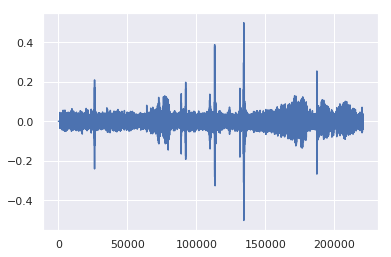

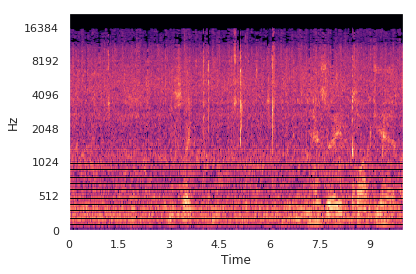

In [0]:
from zipfile import ZipFile 
from scipy.io import wavfile
import matplotlib.pyplot as plt
from librosa.feature import melspectrogram
# specifying the zip file name 
file_name = "train_noisy.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zzip, ZipFile('train_curated.zip', 'r') as zip2: 
    # printing all the contents of the zip file 
    z = zzip
    byte_stream = io.BytesIO(z.read('0de463ec.wav'))
    sr, wav = wavfile.read(byte_stream)

wav = wav[0:5*sr]
wav = (wav)/(np.max(wav) - np.min(wav))
plt.plot(wav)
plt.figure()
S = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=224, fmax=22050, n_fft=1024)
print(S.shape)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=22050, x_axis='time')

In [0]:
import librosa
import pandas as pd

df_curated = pd.read_csv(r'train_curated.csv')
df_noisy = pd.read_csv(r'train_noisy.csv')
df_curated['ZipDir'] = 'c'
df_noisy['ZipDir'] = 'n'
df = df_noisy
df = pd.concat([df_curated, df_noisy])
df['labels'] = df['labels'].apply(lambda x: x.split(','))

label_set = set(x for l in df['labels'] for x in l)
assert len(label_set) == 80
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,fname,labels,ZipDir
0,8f3c6729.wav,"[Marimba_and_xylophone, Glockenspiel]",n
1,37e37606.wav,"[Cupboard_open_or_close, Drawer_open_or_close]",n
2,49f9ab2d.wav,"[Bathtub_(filling_or_washing), Drip]",n
3,921d7872.wav,"[Dishes_and_pots_and_pans, Cutlery_and_silverw...",n
4,fe6ed34b.wav,[Acoustic_guitar],n


In [0]:
lb = preprocessing.MultiLabelBinarizer(classes=list(label_set))
filenames = df[['ZipDir', 'fname']]
bin_labels = lb.fit_transform(df['labels'])

In [0]:
filenames['fname'][0]

'bbcd18e5.wav'

In [0]:
def change_pitch(y, sr):
    bins_per_octave = 12
    pitch_pm = 4
    pitch_change =  pitch_pm * 2 * (np.random.uniform())   
    y_pitch = librosa.effects.pitch_shift(y, 
                                          sr, 
                                          n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return y

def time_stretch(y, sr):
    input_length = len(y)
    rate = np.random.uniform(0.80,1.25)
    y = librosa.effects.time_stretch(y.astype('float32'), rate)
    if len(y) < input_length:
        y = np.pad(y, (0, max(0, input_length - len(y))), "constant")
    return y

def add_noise(y, sr):
    noise_amp = 0.005*np.random.uniform()*np.max(y)
    y = y + noise_amp * np.random.normal(size=y.shape)
    return y

def rand_shift(y,sr): 
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
    start = int(y.shape[0] * timeshift_fac)
    if (start > 0):
        y = np.pad(y,(start,0),mode='constant')
    else:
        y = np.pad(y,(0,-start),mode='constant')
    return y
# augmentors = [add_noise, add_noise, add_noise]
augmentors = [add_noise, add_noise, add_noise, add_noise, rand_shift, time_stretch, change_pitch ]

In [0]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import Progbar
from zipfile import ZipFile 
from scipy.io import wavfile
import matplotlib.pyplot as plt

class FreesoundSeq(Sequence):
    def __init__(self, files, bin_labels, batch_size = 8, max_len = 5*44544):
        self.files, self.bin_labels = files, bin_labels
        self.batch_size = batch_size
        self.max_len = max_len
        self.sr = 44100

    def __len__(self):
        return 100

    def __getitem__(self, idx):
        batch_indices = np.random.choice(a = len(self.files), size = self.batch_size)
        batch_y = self.bin_labels[batch_indices]
        batch_x = []
        with ZipFile(file_names[0], 'r') as zip_n, ZipFile(file_names[1], 'r') as zip_c: 
            for index in range(len(batch_indices)):
                ind = batch_indices[index]
                x = None
                z = zip_n if self.files['ZipDir'][ind] == 'n' else zip_c 
                byte_stream = io.BytesIO(z.read(self.files['fname'][ind]))
                sr, x = wavfile.read(byte_stream)
                x = 4*(wav)/(np.max(wav) - np.min(wav))
                self.sr = sr
                for i in np.random.choice(a = augmentors, size = 1):
                    x = i(x,sr)
                if len(x)>self.max_len:
                    n = len(x)
                    x = x[n//4:3*n//4]
                    if len(x)>self.max_len:
                        max_shift = len(x) - self.max_len
                        s = np.random.randint(0, max_shift)
                        x = x[s:s+self.max_len]
                x, zero_index = librosa.effects.trim(x)
                if len(x) < self.max_len:
                    x = np.pad(x, (0, self.max_len - len(x)), 'constant')
                batch_x.append(x)
        batch_x = pad_sequences(batch_x, padding='post', dtype='float32')
        batch_x = np.expand_dims(batch_x, -1)
        return (batch_x, batch_y)
    
freesoundDataSeq = FreesoundSeq(filenames, bin_labels, batch_size = 24, max_len = 5*44544)

In [0]:
def get_weights(i, start, stop, shape, **kwargs):
    num = 227
    freq = np.logspace(start, stop, num=num, endpoint=False, base=1.61803398875)
    w_n = shape[0]
    b_n = 3
    w_1 = np.reshape(signal.firwin(w_n, cutoff = [freq[i], freq[num - 1]],  window = ('kaiser', 1), pass_zero = False), (w_n, 1, 1))
    w_2 = np.reshape(signal.firwin(w_n, cutoff = [freq[0],     freq[i+2]],  window = ('kaiser', 1), pass_zero = False), (w_n, 1, 1))
    w_3 = np.reshape(signal.firwin(w_n, cutoff = [freq[i-1],   freq[i+2]], window = ('kaiser', 1), pass_zero = False), (w_n, 1, 1))
    w = np.concatenate([w_1, w_2, w_3], axis = -1)
    return w

def conv1d_reg(weight_matrix):
    orthogonality = K.abs(K.sum(weight_matrix**2) - 1.0)
    symmetry = K.mean(weight_matrix)
    return 0.001*(orthogonality + symmetry)

In [0]:
inp = Input(shape=(5*44544,1))
# inp = BatchNormalization()(inp)
m = []
t = Reshape((435, 512))(inp)
t = CuDNNLSTM(4, return_sequences=True)(t)
t = SeparableConv1D(4, kernel_size=1024, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=None, activation='relu')(t)
r = t
# inp = Conv1D(16, kernel_size=1024, strides=512, padding='same', kernel_initializer='he_normal', kernel_regularizer=None, activation='sigmoid')(inp)
for i in range(1, 225):
    ker_init = partial(get_weights, i, -16.1803398875, 0.07125)
    L = SeparableConv1D(4, kernel_size= 2048, strides=1, padding='same', kernel_initializer='he_normal', kernel_constraint= max_norm(4.0) , kernel_regularizer=l2(), activation=None)
    t = L(t)
    t = CuDNNLSTM(4, return_sequences=True)(t)
    t = LeakyReLU()(t)
    t = Add()([t, r])
    t = BatchNormalization()(t)
    m.append(Lambda(lambda x: K.expand_dims(x,1))(t))

y = Lambda(lambda x: K.concatenate(x, axis = 1))(m) 

x = BatchNormalization()(y)
x = Conv2D(16, kernel_size=(112,3), padding='same', activation=None)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2)(x)
x = Conv2D(64, kernel_size=(43, 1), padding='same', activation=None)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2)(x)
x = Conv2D(384, kernel_size=(21, 1), padding='same', activation=None)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2)(x)
x = Conv2D(512, kernel_size=(7, 1), padding='same', activation=None)(x)
x = LeakyReLU()(x)
# x = BatchNormalization()(x)
# mn = MobileNetV2(include_top=False, weights = 'imagenet')
# mn.layers.pop(0)

# mn_out = mn(x)
x = GlobalAveragePooling2D()(x)
x = Dense(384, activation='relu')(x)
x = LeakyReLU()(x)
x_0 = BatchNormalization()(x)
x = Dense(384, activation='relu')(x_0)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dense(384, activation='relu')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dense(384, activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_0])
sig = Dense(80, activation='relu', kernel_constraint=max_norm(2))(x)
sftmx = Dense(80, activation='softmax')(x)

x = Add()([sig, sftmx])

x = Lambda(lambda _x: K.clip(_x,0,1))(x)

model = Model(inputs=[inp], outputs=x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 222720, 1)]  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 435, 512)     0           input_3[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_450 (CuDNNLSTM)      (None, 435, 4)       8288        reshape_2[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_450 (Separable (None, 435, 4)       4116        cu_dnnlstm_450[0][0]             
____________________________________________________________________________________________

In [0]:
def tf_one_sample_positive_class_precisions(y_true, y_pred) :
    num_samples, num_classes = y_pred.shape
    
    # find true labels
    pos_class_indices = tf.where(y_true > 0) 
    
    # put rank on each element
    retrieved_classes = tf.nn.top_k(y_pred, k=num_classes).indices
    sample_range = tf.zeros(shape=tf.shape(tf.transpose(y_pred)), dtype=tf.int32)
    sample_range = tf.add(sample_range, tf.range(tf.shape(y_pred)[0], delta=1))
    sample_range = tf.transpose(sample_range)
    sample_range = tf.reshape(sample_range, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_classes = tf.reshape(retrieved_classes, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_class_map = tf.concat((sample_range, retrieved_classes), axis=0)
    retrieved_class_map = tf.transpose(retrieved_class_map)
    retrieved_class_map = tf.reshape(retrieved_class_map, (tf.shape(y_pred)[0], num_classes, 2))
    
    class_range = tf.zeros(shape=tf.shape(y_pred), dtype=tf.int32)
    class_range = tf.add(class_range, tf.range(num_classes, delta=1))
    
    class_rankings = tf.scatter_nd(retrieved_class_map,
                                          class_range,
                                          tf.shape(y_pred))
    
    #pick_up ranks
    num_correct_until_correct = tf.gather_nd(class_rankings, pos_class_indices)

    # add one for division for "presicion_at_hits"
    num_correct_until_correct_one = tf.add(num_correct_until_correct, 1) 
    num_correct_until_correct_one = tf.cast(num_correct_until_correct_one, tf.float32)
    
    # generate tensor [num_sample, predict_rank], 
    # top-N predicted elements have flag, N is the number of positive for each sample.
    sample_label = pos_class_indices[:, 0]   
    sample_label = tf.reshape(sample_label, (-1, 1))
    sample_label = tf.cast(sample_label, tf.int32)
    
    num_correct_until_correct = tf.reshape(num_correct_until_correct, (-1, 1))
    retrieved_class_true_position = tf.concat((sample_label, 
                                               num_correct_until_correct), axis=1)
    retrieved_pos = tf.ones(shape=tf.shape(retrieved_class_true_position)[0], dtype=tf.int32)
    retrieved_class_true = tf.scatter_nd(retrieved_class_true_position, 
                                         retrieved_pos, 
                                         tf.shape(y_pred))
    # cumulate predict_rank
    retrieved_cumulative_hits = tf.cumsum(retrieved_class_true, axis=1)

    # find positive position
    pos_ret_indices = tf.where(retrieved_class_true > 0)

    # find cumulative hits
    correct_rank = tf.gather_nd(retrieved_cumulative_hits, pos_ret_indices)  
    correct_rank = tf.cast(correct_rank, tf.float32)

    # compute presicion
    precision_at_hits = tf.truediv(correct_rank, num_correct_until_correct_one)

    return pos_class_indices, precision_at_hits

def tf_lwlrap(y_true, y_pred):
    num_samples, num_classes = y_pred.shape
    pos_class_indices, precision_at_hits = (tf_one_sample_positive_class_precisions(y_true, y_pred))
    pos_flgs = tf.cast(y_true > 0, tf.int32)
    labels_per_class = tf.reduce_sum(pos_flgs, axis=0)
    weight_per_class = tf.truediv(tf.cast(labels_per_class, tf.float32),
                                  tf.cast(tf.reduce_sum(labels_per_class), tf.float32))
    sum_precisions_by_classes = tf.zeros(shape=(num_classes), dtype=tf.float32)  
    class_label = pos_class_indices[:,1]
    sum_precisions_by_classes = tf.unsorted_segment_sum(precision_at_hits,
                                                        class_label,
                                                       num_classes)
    labels_per_class = tf.cast(labels_per_class, tf.float32)
    labels_per_class = tf.add(labels_per_class, 1e-7)
    per_class_lwlrap = tf.truediv(sum_precisions_by_classes,
                                  tf.cast(labels_per_class, tf.float32))
    out = tf.cast(tf.tensordot(per_class_lwlrap, weight_per_class, axes=1), dtype=tf.float32)
    return out

def tf_lwlrap_loss(y_true, y_pred):
    l = tf_lwlrap(y_true, y_pred)
    return 50*(1-l)

In [0]:
def custom_loss(y_true, y_pred):
    return 100*K.categorical_crossentropy(y_true, y_pred)

In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import math
def step_decay(epoch):
    initial_lrate = .01
    drop = 0.98
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, np.floor((1+epoch)/epochs_drop))
    return lrate
lr_scheduler = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='tf_lwlrap', factor=0.2, patience=5, min_lr=0.001)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='./gdrive/My Drive/Freesound/prototype_v5-weights-{epoch:03d}-{tf_lwlrap:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='tf_lwlrap', verbose=1, save_best_only=True, mode='max', save_freq = 1, save_weights_only= True)

In [0]:
from tensorflow.keras import losses, optimizers
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999), loss=custom_loss, metrics=[custom_loss, tf_lwlrap, 'acc'])

W0621 10:41:44.870028 140608430872448 deprecation.py:323] From <ipython-input-13-83b5d3117a7a>:5: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
hist = model.fit_generator(freesoundDataSeq, 
                    epochs=20,
                    callbacks = [reduce_lr],
                    use_multiprocessing=False,
                    workers=2,
                    verbose = 1)

Epoch 1/20
100/100 [==============================] - 838s 8s/step - loss: 735.0652 - custom_loss: 735.0653 - tf_lwlrap: 0.0688 - acc: 0.0171
Epoch 2/20
100/100 [==============================] - 589s 6s/step - loss: 708.9361 - custom_loss: 708.9360 - tf_lwlrap: 0.0749 - acc: 0.0179
Epoch 3/20
100/100 [==============================] - 597s 6s/step - loss: 697.0669 - custom_loss: 697.0668 - tf_lwlrap: 0.0660 - acc: 0.0117
Epoch 4/20
100/100 [==============================] - 603s 6s/step - loss: 637.4144 - custom_loss: 637.4145 - tf_lwlrap: 0.0631 - acc: 0.0104
Epoch 5/20
100/100 [==============================] - 598s 6s/step - loss: 621.2956 - custom_loss: 621.2955 - tf_lwlrap: 0.0662 - acc: 0.0113
Epoch 6/20
100/100 [==============================] - 600s 6s/step - loss: 621.0447 - custom_loss: 621.0446 - tf_lwlrap: 0.0714 - acc: 0.0175
Epoch 7/20
100/100 [==============================] - 602s 6s/step - loss: 622.9140 - custom_loss: 622.9141 - tf_lwlrap: 0.0652 - acc: 0.0125
Epoch 